In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer
from scipy.special import binom
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy.stats import jarque_bera
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statistics
import math
import scipy.stats as stats
import random
import itertools
import matplotlib.dates as mdates
import warnings
import pickle
warnings.filterwarnings('ignore')

In [2]:
def get_lagged_vars(df,iv,lags,freq = "D"):
    '''
    Desc:
    Create new columns in df. These columns are just shifts of the original columns, and referred as 
    lagged variables.
    
    Parameters:
    df: pandas dataframe
    iv: list of column names from df. These are the independent variables
    lags: list of non-negative integers
    freq: frequency of the dattimeindex of df. default is "D"
    
    Output:
    updates df with new lagged variable columns and list of lagged variabls
    '''
    iv_wLags = list(iv)
    for v in iv:
        for l in lags:
            new_name = v + "_lag" + str(l)
            df[new_name] = df[v].shift(l, freq = freq)
    df.drop
    return df,iv_wLags

# Load OOS & In-Sample Data. Load Models

In [3]:
iv = ['DBAA', 'DCOILWTICO', 'OVXCLS', 'SP500','T10YIE', 'VIXCLS']
oos = pd.read_csv('OOS_fred_data.csv', index_col = 'date')

# fill in missing days - linear interpolation
idx = pd.date_range(oos.index.min(), oos.index.max())
oos.index = pd.DatetimeIndex(oos.index)
oos = oos.reindex(idx).interpolate()

# get lagged variables
oos,iv_wLags = get_lagged_vars(oos,iv,lags = [0,7,14])

# get only dates outside of training data
oos = oos[oos.index > '2022-02-07']

# dv
dv = 'CBBTCUSD'

# Read in-sample data
df = pd.read_csv('fred_data.csv', index_col = 'date')

# fill in missing days - linear interpolation
idx = pd.date_range(df.index.min(), df.index.max())
df.index = pd.DatetimeIndex(df.index)
df = df.reindex(idx).interpolate()

# get lagged variables
df,iv_wLags = get_lagged_vars(df,iv,lags = [0,7,14])

# load arimax models
with open('arimax.pickle', 'rb') as f:
    arimax_models = pickle.load(f)

# load OLS models
with open('OLS.pickle', 'rb') as f:
    OLS_models = pickle.load(f)
    
# load arima model
with open('arima.pickle', 'rb') as f:
    arima_models = pickle.load(f)
    

# ARIMAX Plots

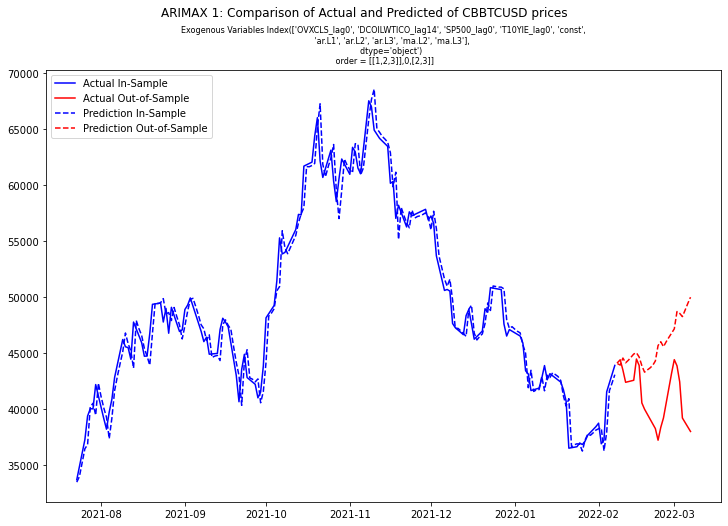

In [8]:
# Get Arimax model
a1 = arimax_models[1]

# Prep OOS data
a1_data = oos[['OVXCLS_lag0', 'DCOILWTICO_lag14', 'SP500_lag0', 'T10YIE_lag0']]
a1_data = sm.add_constant(a1_data, prepend = False)

#Plot and compare
fig, axs = plt.subplots(1,1,figsize = (10,7.2), constrained_layout = True)
plt.suptitle('ARIMAX 1: Comparison of Actual and Predicted of {} prices'.format(dv))
plt.title('Exogenous Variables {}\n order = {}'.format(a1.params[:-1].index,'[[1,2,3]],0,[2,3]]'),
          fontsize = 8
         )
# Actuals
plt.plot(df[dv][-200:], color = 'blue')
plt.plot(oos[dv], color = 'red')

# predictions
x = df[df.index >= '2016-06-01']
pred1_is = a1.predict(start = x.index[0], end = x.index[-1],exog = x)
plt.plot(pred1_is[-200:], '--',color = 'blue')
pred1_oos = a1.predict(start = a1_data.index[0], end = a1_data.index[-1], exog = a1_data)
plt.plot(pred1_oos, '--',  color = 'red')

plt.legend(["Actual In-Sample","Actual Out-of-Sample","Prediction In-Sample", "Prediction Out-of-Sample"], loc = 'upper left')

plt.show()

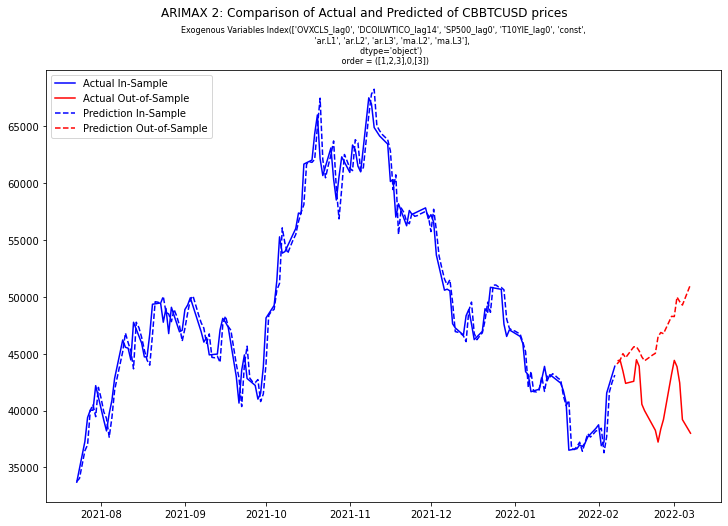

In [5]:
# Get Arimax model
a2 = arimax_models[2]

# Prep OOS data
a2_data = oos[['OVXCLS_lag0', 'DCOILWTICO_lag14', 'SP500_lag0', 'T10YIE_lag0','VIXCLS_lag14']]
a2_data = sm.add_constant(a2_data, prepend = False)

#Plot and compare
fig, axs = plt.subplots(1,1,figsize = (10,7.2), constrained_layout = True)
plt.suptitle('ARIMAX 2: Comparison of Actual and Predicted of {} prices'.format(dv))
plt.title('Exogenous Variables {}\n order = {}'.format(a1.params[:-1].index,'([1,2,3],0,[3])'),
          fontsize = 8
         )
# Actuals
plt.plot(df[dv][-200:], color = 'blue')
plt.plot(oos[dv], color = 'red')

# predictions
x = df[df.index >= '2016-06-01']
pred2_is = a2.predict(start = x.index[0], end = x.index[-1],exog = x)
plt.plot(pred2_is[-200:], '--',color = 'blue')
pred2_oos = a2.predict(start = a2_data.index[0], end = a2_data.index[-1], exog = a2_data)
plt.plot(pred2_oos, '--',  color = 'red')

plt.legend(["Actual In-Sample","Actual Out-of-Sample","Prediction In-Sample", "Prediction Out-of-Sample"], loc = 'upper left')

plt.show()

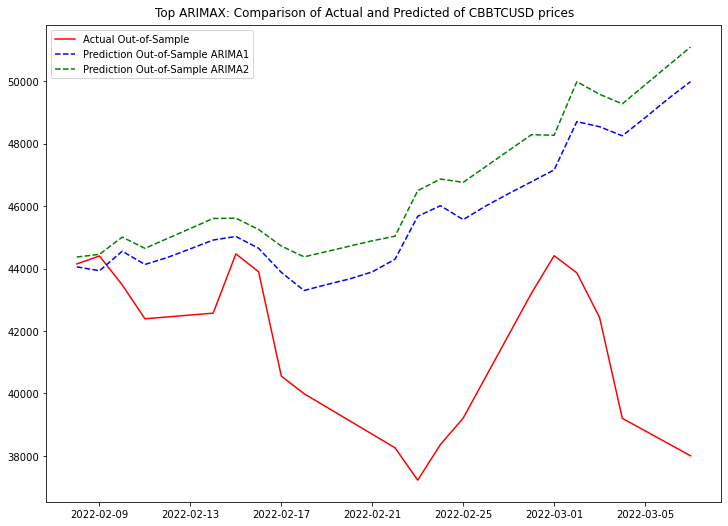

In [9]:
#Plot and compare
fig, axs = plt.subplots(1,1,figsize = (10,7.2), constrained_layout = True)
plt.suptitle('Top ARIMAX: Comparison of Actual and Predicted of {} prices'.format(dv))

# Actuals
plt.plot(oos[dv], color = 'red')
plt.plot(pred1_oos, '--',  color = 'blue')
plt.plot(pred2_oos, '--',  color = 'green')

plt.legend(["Actual Out-of-Sample", "Prediction Out-of-Sample ARIMA1","Prediction Out-of-Sample ARIMA2"], loc = 'upper left')

plt.show()

# OLS Plots & Analysis

In [10]:
def plot_ols(rank,model,oos,in_sample,dv):
    # Prep OOS data
    oos_data = oos[model.params[:-1].index]
    oos_data = sm.add_constant(oos_data, prepend = False)

    #Plot and compare
    fig, axs = plt.subplots(1,1,figsize = (10,7.2), constrained_layout = True)
    plt.suptitle('OLS {}: Comparison of Actual and Predicted of {} prices'.format(rank,dv))
    plt.title('Exogenous Variables {}'.format(model.params[:-1].index),
              fontsize = 8
             )
    # Actuals
    plt.plot(in_sample[dv][-200:], color = 'blue')
    plt.plot(oos[dv], color = 'red')

    # predictions
    x = in_sample[in_sample.index >= '2016-06-01']
    x = x[oos_data.columns[:-1]]
    x = sm.add_constant(x,prepend = False)
    pred_is = model.predict(x)
    plt.plot(pred_is[-200:], '--',color = 'blue')
    pred_oos = model.predict(oos_data)
    plt.plot(pred_oos, '--',  color = 'red')

    plt.legend(["Actual In-Sample","Actual Out-of-Sample","Prediction In-Sample", "Prediction Out-of-Sample"], loc = 'upper left')

    plt.show()

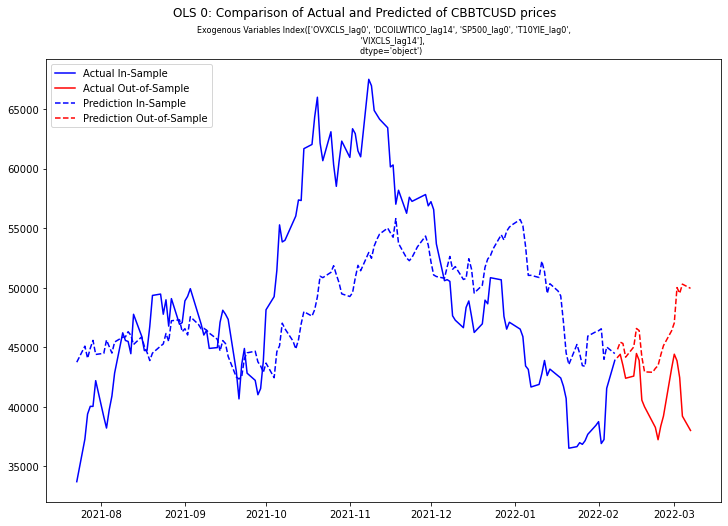

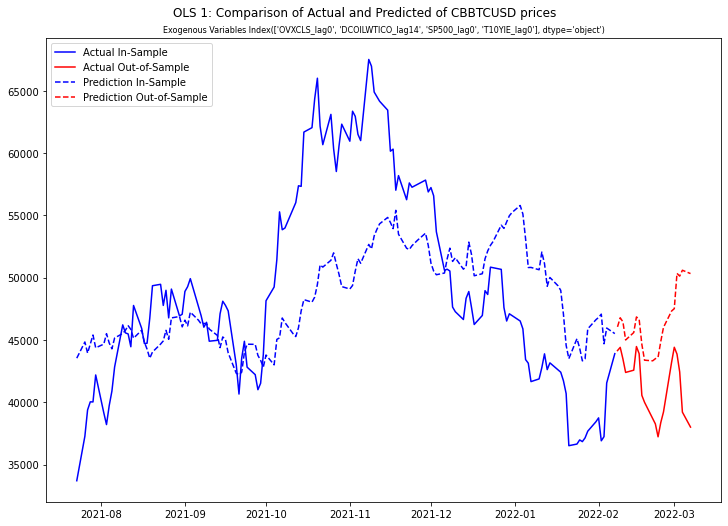

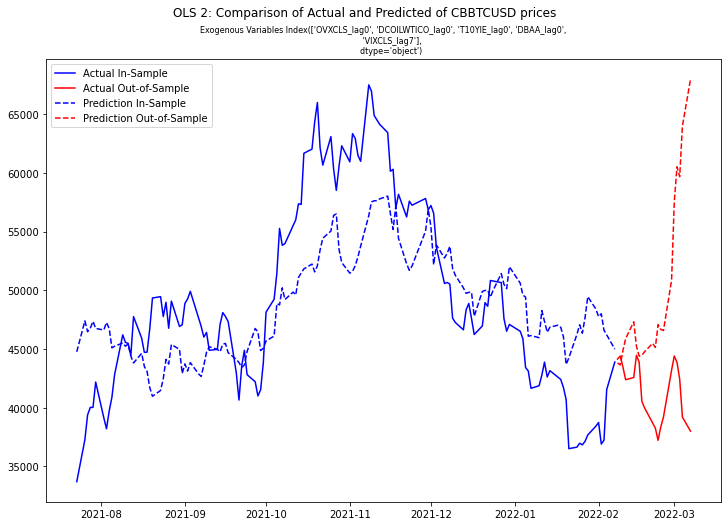

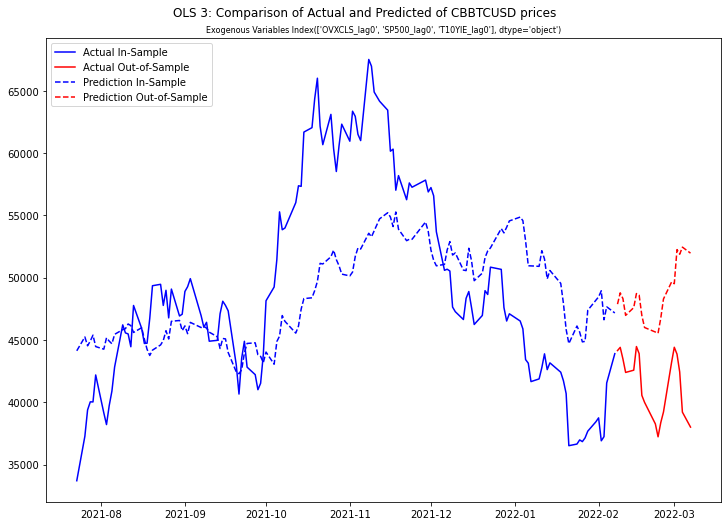

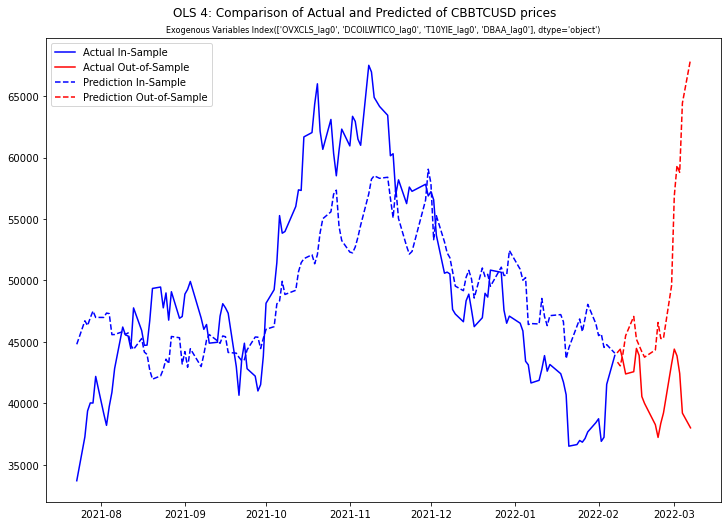

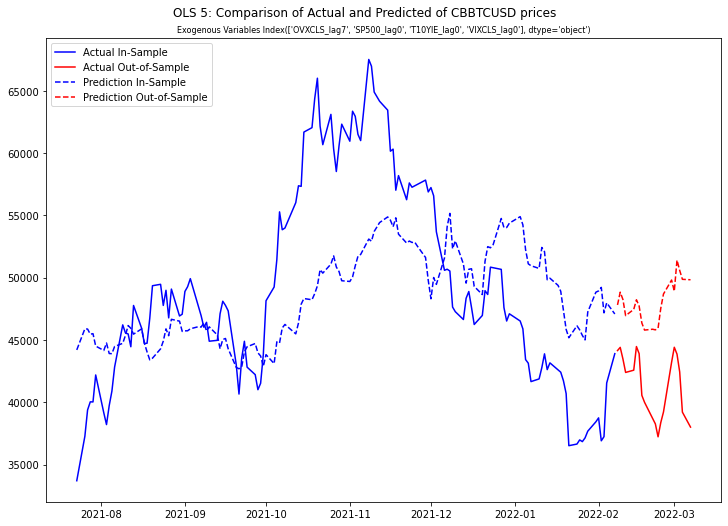

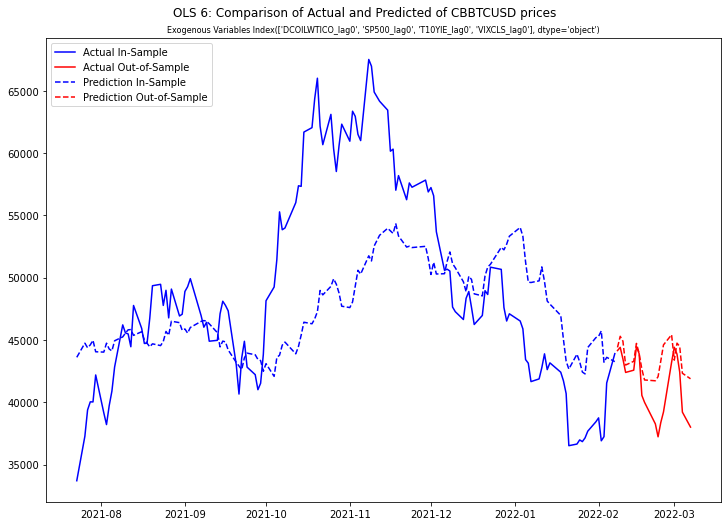

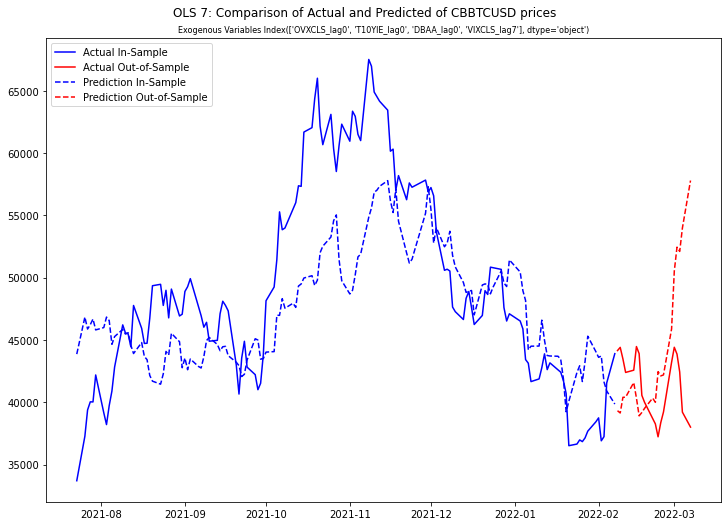

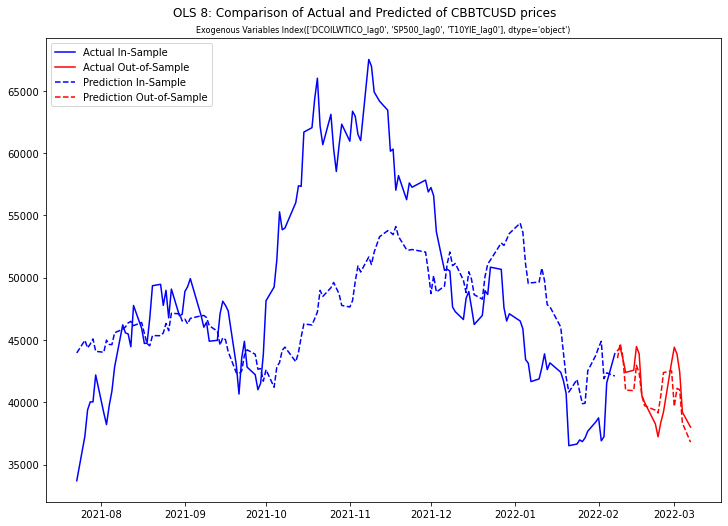

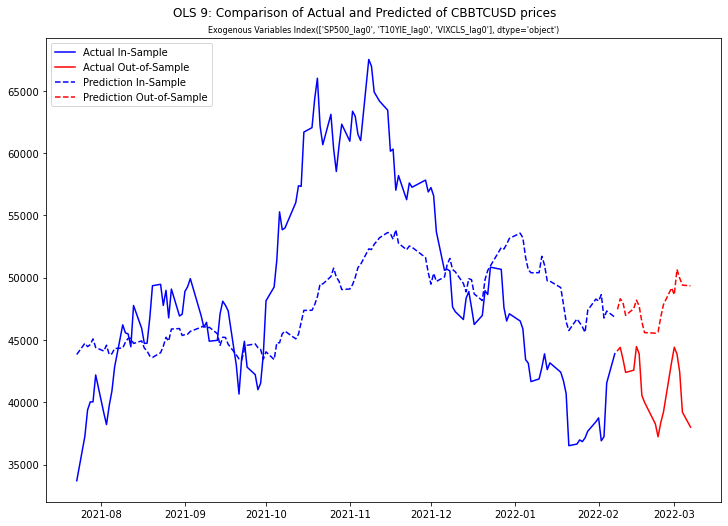

In [11]:
for rank in OLS_models.keys():
    model = OLS_models[rank]
    plot_ols(rank, model, oos, df, dv)

# ARIMA Model

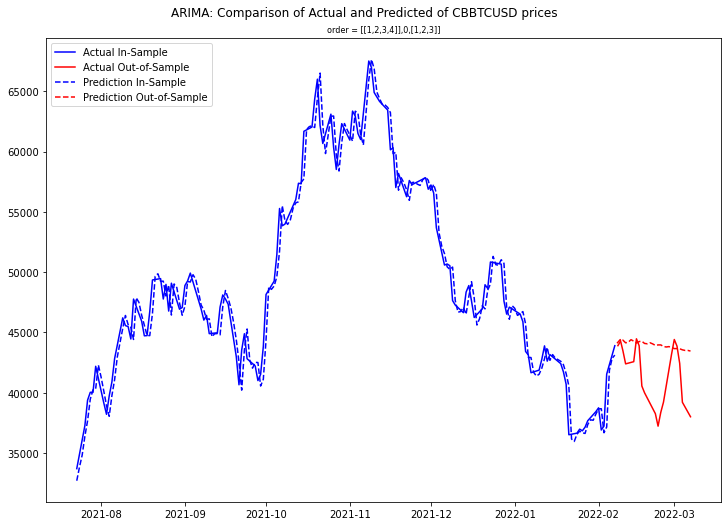

In [21]:
# Get Arima model
arima = arima_models

#Plot and compare
fig, axs = plt.subplots(1,1,figsize = (10,7.2), constrained_layout = True)
plt.suptitle('ARIMA: Comparison of Actual and Predicted of {} prices'.format(dv))
plt.title('order = {}'.format('[[1,2,3,4]],0,[1,2,3]]'),
          fontsize = 8
         )
# Actuals
plt.plot(df[dv][-200:], color = 'blue')
plt.plot(oos[dv], color = 'red')

# predictions
x = df[df.index >= '2016-06-01']
pred_arima_is = arima.predict(start = x.index[0], end = x.index[-1])
plt.plot(pred_arima_is[-200:], '--',color = 'blue')

pred_arima_oos = arima.predict(start = a1_data.index[0], end = a1_data.index[-1])
plt.plot(pred_arima_oos, '--',  color = 'red')

plt.legend(["Actual In-Sample","Actual Out-of-Sample","Prediction In-Sample", "Prediction Out-of-Sample"], loc = 'upper left')

plt.show()

# All Models in OOS

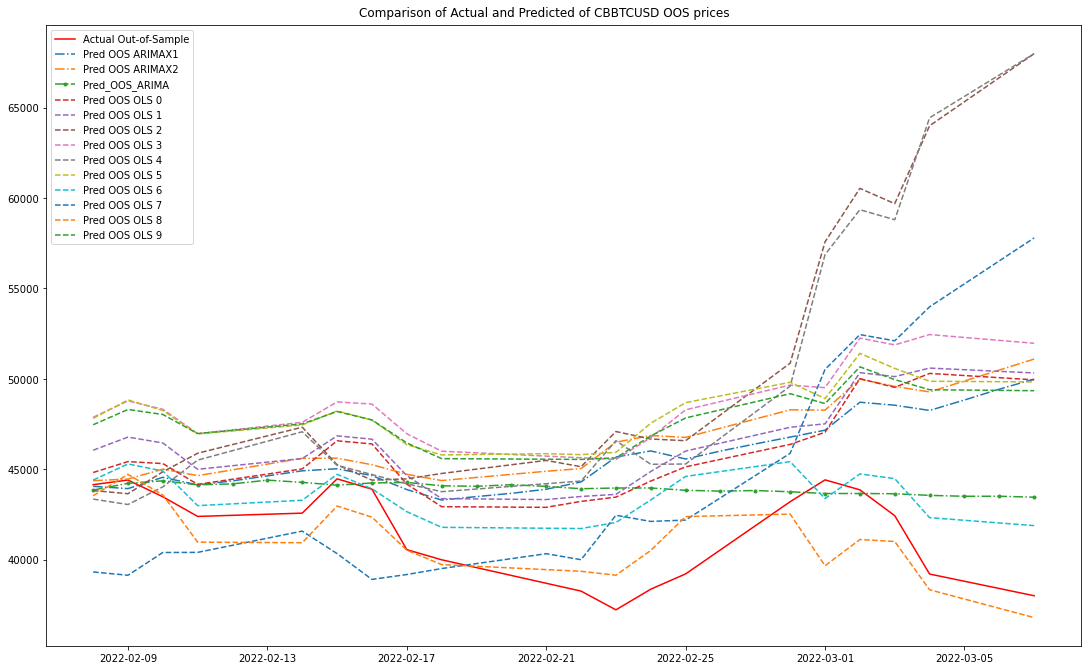

In [27]:
#Plot and compare
fig, axs = plt.subplots(1,1,figsize = (15,9.2), constrained_layout = True)
plt.suptitle('Comparison of Actual and Predicted of {} OOS prices'.format(dv))

# OOS preds
oos_pred = {'arimax1' : pred1_oos,
            'arimax2' : pred2_oos,
            'arima' : pred_arima_oos
           }

# Legend 
legend = ["Actual Out-of-Sample", "Pred OOS ARIMAX1","Pred OOS ARIMAX2",'Pred_OOS_ARIMA']
# Actuals
plt.plot(oos[dv], color = 'red')
plt.plot(pred1_oos, '-.')
plt.plot(pred2_oos, '-.')
plt.plot(pred_arima_oos, '.-.')
for rank in OLS_models.keys():
    oos_data = oos[OLS_models[rank].params[:-1].index]
    oos_data = sm.add_constant(oos_data, prepend = False)
    pred_oos = OLS_models[rank].predict(oos_data)
    oos_pred['OLS{}'.format(rank)] = pred_oos
    plt.plot(pred_oos, '--')
    legend.append('Pred OOS OLS {}'.format(rank))

plt.legend(legend, loc = 'upper left')

plt.show()

In [61]:
for key in oos_pred.keys():
    mse = 0
    for entry in range(len(oos_pred[key])):
        mse += (oos_pred[key][entry] - oos.CBBTCUSD[entry])**2
    rmse = mse ** (0.5)
    print(f'{key:7}',f'{rmse:.2f}')
    
print('\nOLS8, OLS6, and arima have lowest RMSE')

arimax1 29821.94
arimax2 34301.10
arima   19023.55
OLS0    30175.46
OLS1    32430.87
OLS2    66531.56
OLS3    42012.83
OLS4    64926.11
OLS5    38809.94
OLS6    14551.41
OLS7    40090.86
OLS8    8703.88
OLS9    36800.63

OLS8, OLS6, and arima have lowest RMSE
